### Import Libraries

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import backend as K
from keras.layers import BatchNormalization
from tensorflow import keras
from keras.layers import Input, Dense, UpSampling2D, Conv2D, Conv2DTranspose, Flatten, Lambda, Reshape
from tensorflow.keras import layers
from keras.models import Model
from keras.losses import binary_crossentropy
import glob
from numpy import asarray
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from os import listdir
from tensorflow.keras.models import Model, load_model,Sequential
from keras.preprocessing.image import ImageDataGenerator
from skimage.color import rgb2gray, gray2rgb, rgb2lab, lab2rgb
from skimage.io import imsave
from skimage.transform import resize
from skimage.io import imshow

In [13]:
from zipfile import ZipFile
file_name="Autoencoder_images.zip"

with ZipFile(file_name, 'r') as Autoencoder_images:
  Autoencoder_images.extractall()

### Read the data

In [14]:
path = 'Autoencoder_images/'

### Normalize and resize the images

In [15]:
#normalize images
train_datagen= ImageDataGenerator(rescale=1. /255)

In [16]:
#resize images
train = train_datagen.flow_from_directory(path,target_size=(112,112),batch_size=340,class_mode=None)


Found 2797 images belonging to 3 classes.


### convert from rgb to lab

In [17]:
##By iterating on each image we are converting it from RGB to Lab . The Lab image is grey image in L channel. 
##All color info is stored in A and B channel 
#The input to the network will be L channel, so we assig L channel to x vector and assign A and B to y.
x=[]
y=[]
for img in train[0]:
    try:
        lab = rgb2lab(img)
        x.append(lab[:,:,0])
        y.append(lab[:,:,1:] / 128)
    except:
        print('error')
x=np.array(x)
y=np.array(y)
x=x.reshape(x.shape+(1,))
print(x.shape)
print(y.shape)

(340, 112, 112, 1)
(340, 112, 112, 2)


### Encoder and Decoder

In [18]:
# Encoder
model= Sequential()
model.add(Conv2D(7, (3,3), activation='relu', padding='same',strides=2,input_shape=(112,112,1)))
model.add(BatchNormalization())
model.add(Conv2D(14, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(14, (3,3), activation='relu', padding='same',strides=2))
model.add(BatchNormalization())
model.add(Conv2D(28, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(28, (3,3), activation='relu', padding='same',strides=2))
model.add(BatchNormalization())
model.add(Conv2D(56, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(56, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(112, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
          

In [19]:
#Decoder
# for the last layer we use tanh instead of Relu.
# this is because we are colorizing the image in this layer using 2 filters , A and B.
#A and B values range between -1 and 1 so tanh (or hyperbolic tangent is used as it also has the range between -1 and 1
# other functions go from 0 to 1

model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2,2)))
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2,2)))
model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model.add(Conv2D(16, (3,3), activation='relu', padding='same'))
model.add(Conv2D(2, (3,3), activation='tanh', padding='same'))
model.add(UpSampling2D((2,2)))
model.compile(optimizer='adam' ,loss='mse',metrics=['accuracy'])
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 56, 56, 7)         70        
                                                                 
 batch_normalization (BatchN  (None, 56, 56, 7)        28        
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 14)        896       
                                                                 
 batch_normalization_1 (Batc  (None, 56, 56, 14)       56        
 hNormalization)                                                 
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 14)        1778      
                                                                 
 batch_normalization_2 (Batc  (None, 28, 28, 14)      

In [20]:
model.fit(x,y,validation_split=0.1,epochs=100,batch_size=16)
model.save('colorize_autoencoder.h5')

Epoch 1/100
20/20 [==============================] - 12s 68ms/step - loss: 0.0298 - accuracy: 0.5578 - val_loss: 0.0162 - val_accuracy: 0.4570
Epoch 2/100
20/20 [==============================] - 1s 33ms/step - loss: 0.0202 - accuracy: 0.5660 - val_loss: 0.0159 - val_accuracy: 0.6155
Epoch 3/100
20/20 [==============================] - 1s 32ms/step - loss: 0.0195 - accuracy: 0.6017 - val_loss: 0.0157 - val_accuracy: 0.6190
Epoch 4/100
20/20 [==============================] - 1s 32ms/step - loss: 0.0192 - accuracy: 0.6112 - val_loss: 0.0151 - val_accuracy: 0.6193
Epoch 5/100
20/20 [==============================] - 1s 35ms/step - loss: 0.0193 - accuracy: 0.6138 - val_loss: 0.0155 - val_accuracy: 0.6210
Epoch 6/100
20/20 [==============================] - 1s 33ms/step - loss: 0.0188 - accuracy: 0.6191 - val_loss: 0.0154 - val_accuracy: 0.6222
Epoch 7/100
20/20 [==============================] - 1s 33ms/step - loss: 0.0189 - accuracy: 0.6054 - val_loss: 0.0151 - val_accuracy: 0.6221
Epoch

### Model accuracy : 0.5925

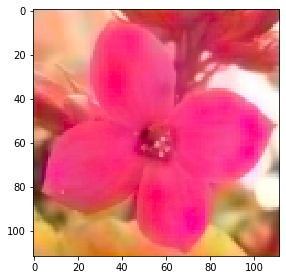

In [24]:
model = tf.keras.models.load_model('colorize_autoencoder.h5',custom_objects=None,compile=True)

img1_color=[]
img1=img_to_array(load_img('Autoencoder_images/C2/flower_0012.jpg'))
img1=resize(img1,(112,112))
img1_color.append(img1)

img1_color= np.array(img1_color,dtype=float)
img1_color =rgb2lab(1.0/255*img1_color)[:,:,:,0]
img1_color =img1_color.reshape(img1_color.shape+(1,))

output1=model.predict(img1_color)
output1=output1*128

result=np.zeros((112,112,3))
result[:,:,0]=img1_color[0][:,:,0]
result[:,:,1:]=output1[0]
imshow(lab2rgb(result))
#imsave("result.png", lab2rgb(result))

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
